# Question 4

Is there some relation between the commenting activity and the decision to stop “depending on” / “contributing to” a package? People may get dissatisfied with some package. In that case, they might either suddenly discontinue using/contributing to that package, or there may be “early signs” of this dissatisfaction in terms of their commenting activity.

In [132]:
import pandas
import matplotlib.pyplot as plt
import seaborn
import collections
import itertools
import numpy as np
import warnings
import subprocess
import requests
import lifelines
import math


import sys
sys.path.append('..')

from helper import load_data , load_repo ,read_comments , GIT_API
warnings.filterwarnings('ignore')

%matplotlib inline

palet = seaborn.color_palette('hls', 8)[0:6]
palet2 = seaborn.color_palette('GnBu_d', 8)[0:8]

#### 1- Read all comments and select commented from contributors and collaborators and owners

In [121]:
all_comments = (
    read_comments()
    [lambda x: x['author_assoc'] != 'NONE']
    .assign(created_at= lambda x: pandas.to_datetime(x['created_at']))
)
all_comments.head()

,Name,user_login,author_assoc,created_at,type
1,itertools,bluss,OWNER,2017-09-05 21:42:56,cmt
2,itertools,DanielKeep,CONTRIBUTOR,2015-06-06 03:52:21,cmt
3,itertools,bluss,OWNER,2015-06-06 07:33:39,cmt
4,itertools,bluss,OWNER,2015-06-06 07:34:31,cmt
5,itertools,DanielKeep,CONTRIBUTOR,2015-06-06 07:43:55,cmt


#### 2- Read Package dependencies with lifespan and elimination status

In [123]:
df_pckdpnd = (
    pandas.read_csv('../data/package_dependencies_time.csv.gz',compression='gzip',
                    parse_dates=['FirstRelease','LastRelease','FirstUse','ExclusionTime'])
    .iloc[:,1:]
)
df_pckdpnd.shape

(48597, 10)

#### 3- Finding contributors commented on a package before stop depending on it

We are creating a new dataframe from comments that created before last time package was used as a dependency so we can compare comments lead to package elimination with those didnt

In [124]:
cntb_cmnts = pandas.DataFrame()
new_data = pandas.DataFrame()
def check_comments(row):
    global cntb_cmnts
    global new_data
    if row['Excluded'] == 0:
        return 0;
    contributors = all_comments[lambda x: x['Name'] == row['package']].user_login.unique()
    cont_depends = all_comments[lambda x: x['Name'] == row['target']][all_comments['user_login'].isin(contributors)][all_comments['created_at'] < row['ExclusionTime']]
    cntb_cmnts = cntb_cmnts.append(cont_depends.reset_index(),ignore_index=True)
    counter = collections.Counter(cont_depends.type.values)
    new_data = new_data.append({
                        "Name": row['package'],
                        "target": row['target'],
                        "ContributorCommentedBeforeUse": cont_depends.user_login.unique() if len(cont_depends)>0 else np.nan,
                        "NumberOfContributors": len(cont_depends.user_login.unique()),
                        "Pulls": counter['pul'] if 'pul' in counter else 0,
                        "Issues": counter['isu'] if 'isu' in counter else 0,
                        "Commit": counter['cmt'] if 'cmt' in counter else 0,
                        "pullRV": counter['prq'] if 'prq' in counter else 0,
                        "CommentsId": cont_depends.index.unique() if len(cont_depends)>0 else np.nan},ignore_index=True)
    return 1;

In [125]:
df_pckdpnd['done'] = df_pckdpnd.apply(lambda row: check_comments(row),axis=1)

In [126]:
df_data = (
    df_pckdpnd
    .drop('done',axis=1)
    .merge(new_data,left_on=['package','target'],right_on=['Name','target'])
    .drop('Name',axis=1)
)

#### 4- Number of packages excluded from dependencies of a package after comment activity of contributor vs other

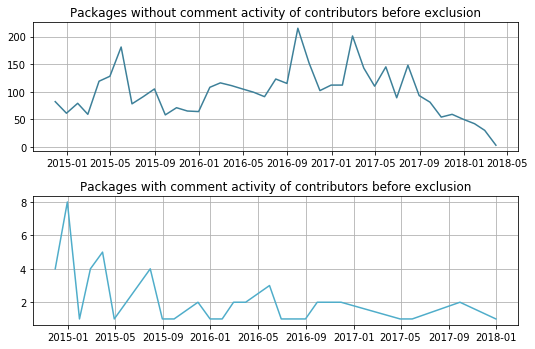

In [156]:
df_tmp_proportion = (
    df_data
    [lambda x: x['Excluded']>0]
    .assign(NumberOfContributors = lambda x: np.where(x['NumberOfContributors']>0,1,0))
    .assign(Count = 1)
    .groupby([pandas.Grouper(key='FirstUse',freq='1M'),'package','target','NumberOfContributors'])
    .sum()
    .reset_index()
    .assign(ContributorsCount = 1)
    .groupby([pandas.Grouper(key='FirstUse',freq='1M'),'NumberOfContributors'])
    .sum()
    .reset_index()
)
plt.rcParams["figure.figsize"] = (16,5)
dic = {1:'Packages with comment activity of contributors before exclusion',0:'Packages without comment activity of contributors before exclusion'}
plt.figure(1)
i = 221
for item in df_tmp_proportion.NumberOfContributors.unique():
    plt.subplot(i)
    plt.plot(df_tmp_proportion[lambda x: x['NumberOfContributors'] == item]['FirstUse'],df_tmp_proportion[lambda x: x['NumberOfContributors'] == item]['ContributorsCount'],color=palet2[i-219])
    plt.title(dic[item])
    plt.grid(True)
    i+=2
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.02)

In [128]:
#unique contributors comment on a package
unique_cmnts = (
    cntb_cmnts
    .sort_values(['Name','user_login','created_at'])
    .drop_duplicates(subset=['Name','user_login'],keep='first')
)

#returns last date that a package was used as dependency if the date is not date of last release
def find_depend_data(index):
    index_of_cmnt = -1
    for id, row in df_data.dropna().iterrows():
        if index in row['CommentsId']:
            index_of_cmnt = id
            break
    return df_data.loc[id]['ExclusionTime'] if df_data.loc[id]['ExclusionTime'] < df_data.loc[id]['LastRelease'] else np.nan

unique_cmnts['ExclusionTime'] = unique_cmnts.apply(lambda r: find_depend_data(r['index']),axis=1)
unique_cmnts['TimeInterval'] = unique_cmnts.dropna().apply(lambda r: (r['ExclusionTime']- r['created_at']).total_seconds()/3600/24,axis=1)
unique_cmnts['Year'] = unique_cmnts.apply(lambda r: r['created_at'].year,axis=1)
unique_cmnts = unique_cmnts.dropna()
#df_sorted_filtered = cntb_cmnts.sort_values(['user_login','Name']).drop_duplicates(subset=['user_login','Name'],keep='last')

#### 5- Time interval between start commenting on a package and stop depending on a package according to type of comment

[Text(0, 0.5, 'Time Interval'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Time Interval between start commenting on a package and stop depending on that')]

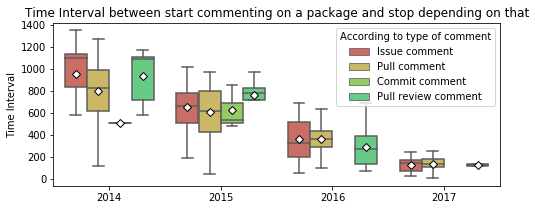

In [158]:
plt.rcParams["figure.figsize"] = (8,3)
fig, ax = plt.subplots()
types = {'isu':'Issue comment','pul':'Pull comment','prq':'Pull review comment','cmt':'Commit comment'}
seaborn.boxplot(
    x='Year', 
    y='TimeInterval', 
    hue='type',
    data=(
        unique_cmnts[['Year','TimeInterval','type']]
        .groupby(['Year','TimeInterval','type'])
        .sum()
        .reset_index()
        .assign(type= lambda x: x['type'].map(types))
    ),
    order=range(2014, 2018),
    palette=palet,
    ax=ax,
    fliersize=1,
    showmeans=True,
    showfliers=False,
    meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='white')
)
ax.legend(title='According to type of comment')
ax.set(
    title='Time Interval between start commenting on a package and stop depending on that',
    ylabel= 'Time Interval',
    xlabel=''
)

#### 6- Percentage of contributors comment activity before stop depending on a package according to type of comment

[Text(3.1999999999999886, 0.5, ''),
 Text(0.5, 3.200000000000003, ''),
 Text(0.5, 1.0, 'Proportion of comment types')]

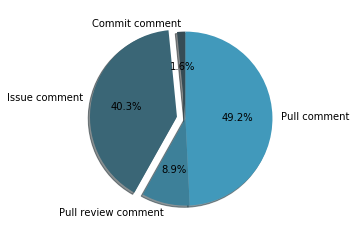

In [143]:
plt.rcParams["figure.figsize"] = (4,4)

df_bar = (unique_cmnts[['Name','ExclusionTime','type']]
        .assign(Proportion = 1)
        .groupby(['type'])
        .sum()
        .reset_index()
        .assign(type= lambda x: x['type'].map(types))
)
df_bar['Proportion'] = df_bar.apply(lambda d: d['Proportion']/df_bar['Proportion'].sum()*100, axis=1)

plt.pie(
    x=df_bar['Proportion'],explode=(0, 0.1, 0, 0), labels=df_bar['type'], colors=palet2,
        autopct='%1.1f%%', shadow=True, startangle=90
)

ax.set(
    xlabel='',
    ylabel='',
    title='Proportion of comment types'
)

#### 7- Monthly distribution of time interval between comment contribution of contributors and stop depending on a package

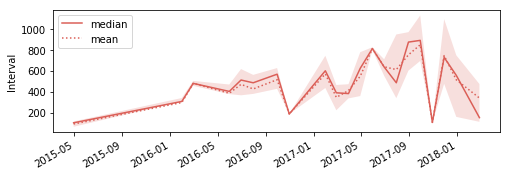

In [145]:
plt.rcParams["figure.figsize"] = (8,2.5)
df_tmp = (
    unique_cmnts
    [['type','ExclusionTime','TimeInterval']]
    .groupby(pandas.Grouper(key='ExclusionTime', freq='1M'))
    ['TimeInterval']
    .describe()
    [['mean','25%','50%','75%']]
    .dropna()
)
fig, ax = plt.subplots()
df_tmp['50%'].rename('median').plot(color=palet, ax=ax)
df_tmp['mean'].plot(color=palet, style=':', ax=ax)
ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], facecolor=palet[0], alpha=0.2)

ax.set(
    xlabel='',
    ylabel='Interval',
    label = 'Interval of start commenting on a package and elimination'
)
ax.legend(loc='upper left')

#### 8- Monthly distribution of lifespan of excluded packages 

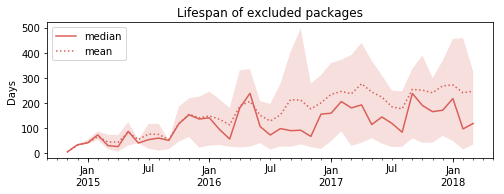

In [147]:
df_tmp = (
    df_data
    [lambda x: x['Excluded']>0]
    [['ExclusionTime','Lifespan']]
    .groupby(pandas.Grouper(key='ExclusionTime', freq='1M'))
    ['Lifespan']
    .describe()
    [['mean', '25%', '50%', '75%']]
    .dropna()
)
fig, ax = plt.subplots()
df_tmp['50%'].rename('median').plot(color=palet, ax=ax)
df_tmp['mean'].plot(color=palet, style=':', ax=ax)
ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], facecolor=palet[0], alpha=0.2)

ax.set(
    title='Lifespan of excluded packages',
    xlabel='',
    ylabel='Days'
)
ax.legend(loc='upper left')

*** is there any relationship between lifespan of an excluded package and commenting activity of contributors??? how can I find 

In [149]:
def com_before_elimination(x):
    return 1 if x['NumberOfContributors']>0 and x['ExclusionTime']<x['LastRelease'] else 0

df_data['ContributorCommented'] = df_data.apply(lambda x: com_before_elimination(x),axis=1)

#### 9- Probability of stop depending on a package 

##### 9-1- Kaplan-Meier method

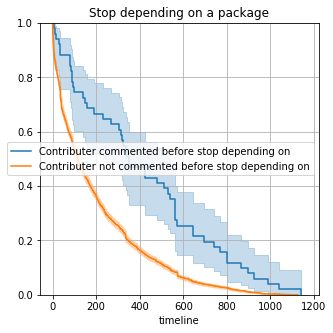

In [160]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
plt.rcParams["figure.figsize"] = (5,5)
ax = plt.subplot(111)

cmnt = (df_data[lambda x: x["ContributorCommented"] == 1])
ncmnt = (df_data[lambda x: x["ContributorCommented"] == 0])
kmf.fit(cmnt['Lifespan'], event_observed=cmnt['Excluded'], label="Contributer commented before stop depending on")
kmf.plot(ax=ax)
kmf.fit(ncmnt['Lifespan'], event_observed=ncmnt['Excluded'], label="Contributer not commented before stop depending on")
kmf.plot(ax=ax)

plt.ylim(0, 1)
plt.grid(True)
plt.title("Stop depending on a package");

##### 9-2- Nelson-Aalen method

          NA_estimate
timeline             
0.000000     0.000000
0.001528     0.000244
0.001574     0.000488
0.001609     0.000976
0.002014     0.001220


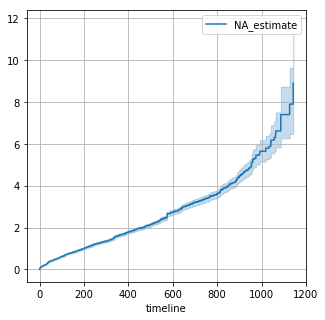

In [162]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()

naf.fit(df_data['Lifespan'], event_observed=df_data['Excluded'])
print(naf.cumulative_hazard_.head())
naf.plot()
plt.grid(True)

##### 9-3- Cumulative hazard function of Nelson-Aalen method

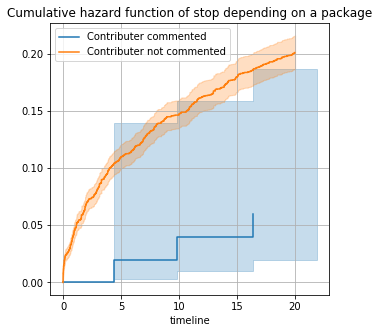

In [163]:
naf.fit(cmnt['Lifespan'], event_observed=cmnt['Excluded'], label="Contributer commented")
ax = naf.plot(loc=slice(0, 20))
naf.fit(ncmnt['Lifespan'], event_observed=ncmnt['Excluded'], label="Contributer not commented")
naf.plot(ax=ax, loc=slice(0, 20))
plt.title("Cumulative hazard function of stop depending on a package");
plt.grid(True)

##### 9-4- Occurrence function of Nelson-Aalen method

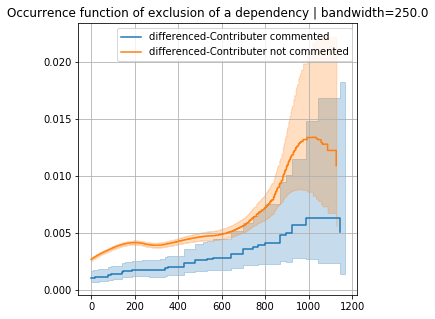

In [170]:
b = 250
naf.fit(cmnt['Lifespan'], event_observed=cmnt['Excluded'], label="Contributer commented")
ax = naf.plot_hazard(bandwidth=b)
naf.fit(ncmnt['Lifespan'], event_observed=ncmnt['Excluded'], label="Contributer not commented")
naf.plot_hazard(ax=ax, bandwidth=b)
plt.title("Occurrence function of exclusion of a dependency | bandwidth=%.1f"%b);
plt.grid(True)